# 2D Unscented Kalman Filter for Pose Estimation

This notebook demonstrates the implementation and benchmarking of the Unscented Kalman Filter (UKF) for 2D pose estimation using outputs from a YOLO-based keypoint detector. It includes dataset evaluation, real-world application, and metric analysis.


## 1. Libraries and Imports

Below, we import all the libraries and dependencies required.

In [41]:
import numpy as np             # Numerical array computations
import pandas as pd            # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting
import matplotlib.patches as mpatches # Plot elements
import seaborn as sns          # Statistical data visualization
import re                      # Regular expressions
import os                      # Operating system interfaces
from scipy.io import loadmat   # Load MATLAB files
from scipy.linalg import sqrtm # Matrix square roots
from glob import glob          # File path matching
from tqdm import tqdm          # Progress bars

import cv2                     # OpenCV: Computer vision operations
from ultralytics import YOLO   # YOLO object detector
import torch                   # PyTorch: Deep learning framework

sns.set_context("notebook", font_scale=1.5) # Set plot theme



## 2. UKF and Metrics: Classes and Utility Functions

Here we define all core classes and key utility functions used throughout the workflow.

---

### Mathematical Foundations of the Unscented Kalman Filter (UKF)

The Unscented Kalman Filter (UKF) is a Bayesian filter designed to estimate the changing state of a nonlinear dynamic system. In STRIKE, a separate UKF is run for each joint trajectory, using noisy 2D keypoints from a YOLO-based detector as observations.

#### UKF State Definition

For each joint, the UKF state vector is:

$$
\mathbf{x} = 
\begin{bmatrix}
x \\
y \\
v \\
\theta \\
\omega
\end{bmatrix}
$$

- \( $x, y$ \): Joint 2D position  
- \( $v$ \): Scalar velocity  
- \( $\theta$ \): Heading angle  
- \( $\omega$ \): Turn rate

#### Filter Algorithm

At each frame \( $k$ \), for each joint, the UKF executes:

1. **Sigma Point Generation**  
   For dimension \( $n$ \), sigma points \( $\chi$ \) are:
   $$
   \chi_0 = \mathbf{x} \\
   \chi_i = \mathbf{x} + \left[\sqrt{(n+\lambda)\mathbf{P}}\right]_i, \quad i=1,\ldots,n \\
   \chi_{i+n} = \mathbf{x} - \left[\sqrt{(n+\lambda)\mathbf{P}}\right]_i, \quad i=1,\ldots,n
   $$
   where \( $\lambda = \alpha^2(n+\kappa) - n$ \).

2. **Prediction (Motion Model)**
   Each sigma point is propagated by the nonlinear motion model (bicycle/travel model):
   $$
   \begin{aligned}
   x_k &= x_{k-1} + \frac{v_{k-1}}{\omega_{k-1}} \left(\sin(\theta_{k-1} + \omega_{k-1} \Delta t) - \sin(\theta_{k-1})\right) \\
   y_k &= y_{k-1} - \frac{v_{k-1}}{\omega_{k-1}} \left(\cos(\theta_{k-1} + \omega_{k-1} \Delta t) - \cos(\theta_{k-1})\right) \\
   v_k &= v_{k-1} \\
   \theta_k &= \theta_{k-1} + \omega_{k-1} \Delta t \\
   \omega_k &= \omega_{k-1}
   \end{aligned}
   $$
   If \( $|\omega|$ \) is very small, use straight-line update:
   $$
   \begin{aligned}
   x_k \approx x_{k-1} + v_{k-1}\Delta t\cos(\theta_{k-1}) \\
   y_k \approx y_{k-1} + v_{k-1}\Delta t\sin(\theta_{k-1})
   \end{aligned}
   $$

3. **Reconstruction of Predicted Mean and Covariance**
   $$
   \hat{\mathbf{x}}^- = \sum_{i=0}^{2n} W_m^{[i]} \chi_i^- \\
   \mathbf{P}^- = \sum_{i=0}^{2n} W_c^{[i]} (\chi_i^- - \hat{\mathbf{x}}^-)(\chi_i^- - \hat{\mathbf{x}}^-)^T + \mathbf{Q}
   $$

4. **Measurement Update**
   - Pass predicted sigma points through the measurement model \( $h(\cdot)$ \), which extracts 2D positions:
   $$
   \gamma_i = h(\chi_i^-) = [x, y]^T
   $$
   - Compute predicted observation and innovation:
   $$
   \hat{\mathbf{z}} = \sum_{i=0}^{2n} W_m^{[i]} \gamma_i \\
   \mathbf{S} = \sum_{i=0}^{2n} W_c^{[i]} (\gamma_i - \hat{\mathbf{z}})(\gamma_i - \hat{\mathbf{z}})^T + \mathbf{R}
   $$
   - Calculate cross-covariance and Kalman gain:
   $$
   \mathbf{T} = \sum_{i=0}^{2n} W_c^{[i]} (\chi_i^- - \hat{\mathbf{x}}^-)(\gamma_i - \hat{\mathbf{z}})^T \\
   \mathbf{K} = \mathbf{T}\mathbf{S}^{-1}
   $$
   - Update state and covariance:
   $$
   \hat{\mathbf{x}} = \hat{\mathbf{x}}^- + \mathbf{K}(\mathbf{z} - \hat{\mathbf{z}}) \\
   \mathbf{P} = \mathbf{P}^- - \mathbf{K}\mathbf{S}\mathbf{K}^T
   $$

#### Complete Sequence Filtering

For each joint:

- **Initialization:** Set filter with YOLO keypoint in the first frame.
- **Loop:** For each frame, if a detection is available, run both predict and update. If not, run predict only (the last estimated state is propagated without correction).
- **Output:** Store the filtered trajectory for downstream evaluation.

#### Benchmark Metric

The main accuracy metric is Mean Per Joint Position Error (MPJPE):
$$
\text{MPJPE} = \frac{1}{NF} \sum_{f=1}^{F} \sum_{n=1}^{N} \lVert \hat{\mathbf{p}}_{f,n} - \mathbf{p}^{\mathrm{GT}}_{f,n} \rVert_2
$$
Where:
- \( $F$ \): Number of frames,
- \( $N$ \): Number of joints,
- \( $\hat{\mathbf{p}}$ \): Filtered keypoint,
- \( $\mathbf{p}^{\mathrm{GT}}$ \): Ground truth keypoint.

---

By modelling velocities and turn rates, the UKF achieves temporally coherent pose estimation and reduces frame-to-frame detection noise, especially for smooth or repetitive sports movements. For highly dynamic actions (e.g., kicks), the model can lag, indicating directions for future research.


In [42]:
class NumpyUKF:
    """
    2D Unscented Kalman Filter for nonlinear tracking.
    """
    def __init__(self, dim_x, dim_z, dt):
        self.dim_x = dim_x      # State dimension
        self.dim_z = dim_z      # Measurement dimension
        self.dt = dt            # Discretization timestep

        # Unscented Transform parameters
        alpha, beta, kappa = 0.1, 2.0, 1.0
        lambda_ = alpha**2 * (dim_x + kappa) - dim_x
        self.Wm = [lambda_ / (dim_x + lambda_)] + [1 / (2 * (dim_x + lambda_))] * (2 * dim_x)  # Weights mean
        self.Wc = [lambda_ / (dim_x + lambda_) + (1 - alpha**2 + beta)] + [1 / (2 * (dim_x + lambda_))] * (2 * dim_x)  # Weights cov

        self.x = np.zeros(dim_x)  # Initial state estimate
        self.P = np.eye(dim_x)    # Initial covariance estimate

    def _generate_sigma_points(self):
        """Create sigma points based on state and covariance."""
        n = self.dim_x
        lambda_ = self.Wm[0] * n / (1 - self.Wm[0])
        try:
            U = np.linalg.cholesky((n + lambda_) * self.P) # Cholesky to get sqrt of P
        except np.linalg.LinAlgError:
            U = sqrtm((n + lambda_) * self.P)              # Fallback to sqrtm if not positive-definite

        sigma_points = np.zeros((2 * n + 1, n))
        sigma_points[0] = self.x                           # First sigma point is mean
        for i in range(n):
            sigma_points[i + 1] = self.x + U[i]
            sigma_points[n + i + 1] = self.x - U[i]
        return sigma_points

    def predict(self, fx, Q):
        """Predict state and covariance forward with process model fx and noise Q."""
        sigma_points = self._generate_sigma_points()
        sigma_points_pred = np.array([fx(sp, self.dt) for sp in sigma_points])
        self.x = np.dot(self.Wm, sigma_points_pred)
        y = sigma_points_pred - self.x[np.newaxis, :]
        self.P = np.dot(y.T, np.diag(self.Wc)).dot(y) + Q

    def update(self, z, hx, R):
        """Incorporate measurement z given measurement function hx and noise R."""
        sigma_points = self._generate_sigma_points()
        sigma_points_meas = np.array([hx(sp) for sp in sigma_points])
        z_pred = np.dot(self.Wm, sigma_points_meas)
        y = sigma_points_meas - z_pred[np.newaxis, :]
        S = np.dot(y.T, np.diag(self.Wc)).dot(y) + R
        T = np.dot((sigma_points - self.x[np.newaxis, :]).T, np.diag(self.Wc)).dot(y)
        K = np.dot(T, np.linalg.inv(S))                    # Kalman gain
        self.x += np.dot(K, z - z_pred)                    # State update
        self.P -= np.dot(K, S).dot(K.T)                    # Covariance update


In [43]:
class PoseMetrics:
    """
    Benchmarking metrics for pose estimation.
    """
    @staticmethod
    def calculate_f1(predicted_points, gt_points, visibility_flags, threshold=25.0):
        # Compute F1 score over all keypoints with visibility mask and distance threshold.
        tp, fp, fn = 0, 0, 0
        for i in range(len(predicted_points)):
            for j in range(predicted_points.shape[1]):
                is_visible = visibility_flags[i, j]
                predicted_pt_exists = np.any(predicted_points[i, j] > 0)
                distance = np.linalg.norm(predicted_points[i, j] - gt_points[i, j])
                if is_visible:
                    if predicted_pt_exists and distance < threshold:
                        tp += 1
                    else:
                        fn += 1
                elif predicted_pt_exists:
                    fp += 1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    @staticmethod
    def calculate_mpjpe(est, gt):
        # Mean Per Joint Position Error (Euclidean)
        return np.mean(np.linalg.norm(est - gt, axis=2))


In [44]:
def motion_model_ukf(x, dt):
    """
    2D kinematic motion model for UKF states:
    x = [pos_x, pos_y, velocity, heading, angular_velocity]
    """
    x_new = np.zeros(5)
    theta, v, omega = x[3], x[2], x[4]
    if abs(omega) < 1e-9:
        x_new[0] = x[0] + v * dt * np.cos(theta)
        x_new[1] = x[1] + v * dt * np.sin(theta)
    else:
        x_new[0] = x[0] + (v / omega) * (np.sin(theta + omega * dt) - np.sin(theta))
        x_new[1] = x[1] - (v / omega) * (np.cos(theta + omega * dt) - np.cos(theta))
    x_new[2] = v
    x_new[3] = theta + omega * dt
    x_new[4] = omega
    return x_new

def measurement_model_ukf(x):
    """
    Measurement model: extracts observed position from state.
    """
    return x[0:2]


---
## 3. UKF Benchmarking on Penn Action Dataset

This section applies the UKF to pose sequences from the labeled Penn Action dataset, aligning the model's output, running filtering, and collecting results.

The dataset can be found at: https://dreamdragon.github.io/PennAction/

**Parameter Choices and Rationale:**

- **Time Step (`dt_ukf = 1.0 / annotations.get('fps', 60)`):**
  - The timestep is set according to the actual FPS of each sequence. If unknown, 60 FPS is assumed. This ensures that the motion model update reflects the correct temporal resolution of the captured movement, preserving trajectory smoothness and filter stability with respect to the dataset's sampling rate.

- **Process Noise Covariance (Q):**
  - `q_pos = 1.5`, `q_vel = 2.0`, `q_turn = 2.5`
  - `Q = np.diag([q_pos, q_pos, q_vel**2, 0.0, q_turn**2])`
  - These values encapsulate realistic variability in position, speed, and angular motion within typical Penn Action sports activities. Smaller `q_pos` (1.5) expects that between frames, well-lit, ground-truth-labeled sequences should have relatively modest random motion noise for stable sports poses. `q_vel` and `q_turn` are slightly larger to tolerate fluctuations in joint speed and direction, accounting for the more variable motion patterns in athletic activity without causing the filter to ignore new evidence.
  - Squaring the velocity and turn rate entries on the diagonal reflects their greater natural scale and uncertainty, particularly in non-linear sports sequences.

- **Measurement Noise Covariance (R):**
  - `r_val = 89.3`
  - `R = np.eye(2) * r_val`
  - This value was empirically determined by evaluating the pixel-level spread of YOLO poses versus ground truth on the dataset. It accounts for detector error, lighting, and occlusion in Penn Action, providing a balanced trade-off: high enough to trust filter predictions when detections are noisy, but not so large as to disregard real corrective information from poses.

*The above parameter choices were guided by minimizing the Mean Per Joint Position Error (MPJPE) and empirically maximizing the filter's ability to retain accuracy without lagging behind rapid athlete motion.*



In [45]:
# --- Keypoint Names ---
yolo_kpts = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle"
]
penn_kpts = [
    "head", "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip", "left_knee",
    "right_knee", "left_ankle", "right_ankle"
]
# List pairs of corresponding index between YOLO and Penn Action definitions (with nose→head mapping)
joint_mapping = [(yolo_kpts.index(name), penn_kpts.index(name))
                 for name in penn_kpts if name in yolo_kpts and name != 'head']
joint_mapping.insert(0, (yolo_kpts.index("nose"), penn_kpts.index("head")))
yolo_indices = [item[0] for item in joint_mapping]
penn_indices = [item[1] for item in joint_mapping]

In [46]:
# --- File and Output Paths ---
frames_root_path = './YOLO-Training/Penn_Action/frames/' # Penn Action frames directory
labels_root_path = './YOLO-Training/Penn_Action/labels/' # Penn Action label (ground truth) directory
output_log_path = 'UKF_benchmark_log.txt'                # Output log file

In [47]:
# --- Dataset Benchmark Loop ---
all_mat_files = sorted(glob(os.path.join(labels_root_path, '*.mat')))
if not all_mat_files:
    raise FileNotFoundError(f"No .mat files found in '{labels_root_path}'")

model = YOLO('yolo11m-pose.pt')    # Load pose estimation model
all_raw_errors, all_filtered_errors = [], []
all_raw_f1, all_filtered_f1 = [], []
log_messages = []

print(f"Starting benchmark for {len(all_mat_files)} action sequences...")

for i, mat_path in enumerate(tqdm(all_mat_files, desc="Processing Sequences")):
    sequence_id = os.path.basename(mat_path).replace('.mat', '')
    frame_sequence_path = os.path.join(frames_root_path, sequence_id)
    try:
        annotations = loadmat(mat_path)
        gt_keypoints = np.stack((annotations['x'], annotations['y']), axis=2)         # Ground-truth keypoints
        visibility = annotations['visibility']                                         # Joint visibility mask
        image_files = sorted(glob(os.path.join(frame_sequence_path, '*.jpg')))
        if not image_files:
            continue

        yolo_keypoints = []
        for img_path in image_files:
            frame = cv2.imread(img_path)
            if frame is None:
                continue
            results = list(model(frame, verbose=False))
            if results and results[0].keypoints and results[0].keypoints.xy.shape[0] > 0:
                yolo_keypoints.append(results[0].keypoints.xy[0].cpu().numpy())
            else:
                yolo_keypoints.append(np.zeros((17, 2)))         # Fill missing with zeros

        if not yolo_keypoints:
            continue
        raw_yolo_output = np.array(yolo_keypoints)
            
        min_frames = min(len(gt_keypoints), len(raw_yolo_output))
        if min_frames < 2:
            continue

        gt_aligned = gt_keypoints[:min_frames, penn_indices, :]
        yolo_aligned = raw_yolo_output[:min_frames, yolo_indices, :]
        visibility_aligned = visibility[:min_frames, penn_indices]

        filtered_output = np.zeros_like(yolo_aligned)
        dt_ukf = 1.0 / annotations.get('fps', 60)
        q_pos, q_vel, q_turn = 1.5, 2.0, 2.5
        Q = np.diag([q_pos, q_pos, q_vel**2, 0.0, q_turn**2])      # Process noise
        r_val = 89.3
        R = np.eye(2) * r_val                                      # Measurement noise

        for joint_idx in range(yolo_aligned.shape[1]):
            ukf = NumpyUKF(dim_x=5, dim_z=2, dt=dt_ukf)            # Create filter per joint
            ukf.x[0:2] = yolo_aligned[0, joint_idx, :]
            ukf.P = np.eye(5) * 500
            for frame_idx in range(min_frames):
                measurement = yolo_aligned[frame_idx, joint_idx, :]
                ukf.predict(fx=motion_model_ukf, Q=Q)              # Predict state
                if np.any(measurement > 0):                        # Only update if detection exists
                    ukf.update(z=measurement, hx=measurement_model_ukf, R=R)
                filtered_output[frame_idx, joint_idx, :] = ukf.x[0:2]

        # Compute metrics
        mpjpe_raw = PoseMetrics.calculate_mpjpe(yolo_aligned, gt_aligned)
        mpjpe_filtered = PoseMetrics.calculate_mpjpe(filtered_output, gt_aligned)
        f1_raw = PoseMetrics.calculate_f1(yolo_aligned, gt_aligned, visibility_aligned)
        f1_filtered = PoseMetrics.calculate_f1(filtered_output, gt_aligned, visibility_aligned)

        all_raw_errors.append(mpjpe_raw)
        all_filtered_errors.append(mpjpe_filtered)
        all_raw_f1.append(f1_raw)
        all_filtered_f1.append(f1_filtered)

        # Log sequence results
        log_messages.append(
            f"[{i+1}/{len(all_mat_files)}] Seq {sequence_id}: "
            f"Raw_MPJPE={mpjpe_raw:.2f}, Filtered_MPJPE={mpjpe_filtered:.2f}, "
            f"Raw_F1={f1_raw:.4f}, Filtered_F1={f1_filtered:.4f}\n"
        )
    except Exception as e:
        log_messages.append(f"Seq {sequence_id}: FAILED. Error: {e}\n")

# Save summary statistics to log file
print(f"\nSaving results to '{output_log_path}'...")
with open(output_log_path, 'w') as f:
    f.writelines(log_messages)
    if all_raw_errors:
        mean_raw_mpjpe = np.mean(all_raw_errors)
        mean_filtered_mpjpe = np.mean(all_filtered_errors)
        mean_raw_f1 = np.mean(all_raw_f1)
        mean_filtered_f1 = np.mean(all_filtered_f1)
        improvement = (mean_raw_mpjpe - mean_filtered_mpjpe) / mean_raw_mpjpe * 100

        summary = (
            "\n" + "="*20 + " FINAL BENCHMARK SUMMARY " + "="*20 + "\n"
            f"Processed {len(all_raw_errors)} of {len(all_mat_files)} sequences successfully.\n\n"
            "--- Positional Accuracy (MPJPE) ---\n"
            f"Mean Raw YOLO Error:      {mean_raw_mpjpe:.4f} pixels\n"
            f"Mean Filtered Error:      {mean_filtered_mpjpe:.4f} pixels\n"
            f"Accuracy Improvement:     {improvement:.2f}%\n\n"
            "--- Detection Reliability (F1-Score) ---\n"
            f"Mean F1-Score for Raw YOLO: {mean_raw_f1:.4f}\n"
            f"Mean F1-Score for UKF:      {mean_filtered_f1:.4f}\n"
            + "="*62
        )
        print(summary)
        f.write(summary)

Starting benchmark for 2326 action sequences...


Processing Sequences:   0%|          | 0/2326 [00:00<?, ?it/s]/tmp/ipykernel_1507876/2343289912.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  sigma_points[i + 1] = self.x + U[i]
/tmp/ipykernel_1507876/2343289912.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  sigma_points[n + i + 1] = self.x - U[i]
Processing Sequences: 100%|██████████| 2326/2326 [1:05:28<00:00,  1.69s/it]


Saving results to 'UKF_benchmark_log.txt'...

==================== FINAL BENCHMARK SUMMARY ====================
Processed 2326 of 2326 sequences successfully.

--- Positional Accuracy (MPJPE) ---
Mean Raw YOLO Error:      76.0592 pixels
Mean Filtered Error:      75.3656 pixels
Accuracy Improvement:     0.91%

--- Detection Reliability (F1-Score) ---
Mean F1-Score for Raw YOLO: 0.4280
Mean F1-Score for UKF:      0.4221


---
## 4. UKF Filtering on Real-World Video

This section demonstrates the use of the UKF on real video data, smoothing detected pose keypoints and visualizing results.

**Parameter Choices and Rationale:**

- **Time Step (`dt = 1.0 / 60.0`):**
  - The time step is set fixed at 60 FPS, matching the real-world video's frame rate. This is a standard rate in sports footage that ensures filter operations are consistent with the video stream's temporal granularity.

- **Process Noise Covariance (Q):**
  - `q_pos = 9.0`, `q_vel = 11.0`, `q_turn = 13.0`
  - `Q = np.diag([q_pos, q_pos, q_vel ** 2, 0.0, q_turn ** 2])`
  - These values are set significantly higher than in the Penn Action experiment. Real video from in-the-wild settings is dramatically more variable: pose detections can skip between occlusion, fast, or abrupt movement, and the lighting/background is highly unconstrained. The larger `q_pos` allows the filter to more readily adapt to sudden changes and fill gaps when YOLO misses a joint, while even greater velocity and turn rate uncertainty reflect unpredictability in actual athlete motion and missing observations.
  - Squaring velocity and turn rate terms, as above, allows for wide natural ranges and abrupt motion changes in open environments.

- **Measurement Noise Covariance (R):**
  - `r_val = 89.3`
  - `R = np.eye(2) * r_val`
  - The measurement noise is held at the same value as the Penn Action setting, since the detection model and expected pixel-level keypoint jitter (for a similarly sized frame) match the worst case observed in labeled data. This helps to avoid overfitting the filter to unreliable measurements in low-quality or occluded frames, still harnessing detection evidence when reliable joints are present.

*Empirical tuning on real-world video showed these more permissive parameters are necessary for the UKF to flexibly model unpredictable poses and avoid temporal lag, especially during high-impact martial arts motions not constrained by lab conditions.*


In [48]:
print("Loading YOLO model...")
model = YOLO('yolo11m-pose.pt')  # Load pretrained YOLO pose estimation model
print("Model loaded.")

video_path = 'treino2.mp4'      # Path to input video file
all_keypoints = []
cap = cv2.VideoCapture(video_path)  # Open video file for reading frames
if not cap.isOpened():
    raise IOError("Cannot open video file")
print("Extracting keypoints...")
while cap.isOpened():
    ret, frame = cap.read()         # Read frame from video
    if not ret:
        break                      # Exit loop at end of video
    results = list(model(frame, verbose=False, device='cuda', stream=True))  # Run pose detection
    # If keypoints are detected, append them; otherwise skip this frame
    if results and results[0].keypoints and results[0].keypoints.xy.shape[0] > 0:
        all_keypoints.append(results[0].keypoints.xy[0].cpu().numpy())
cap.release()                      # Release video capture device

if not all_keypoints:
    print("\nERROR: No skeletons detected.")  # Report absence of detections
else:
    skeleton_data_2d = np.array(all_keypoints)        # Shape: (frames, joints, 2)
    num_frames, num_joints, _ = skeleton_data_2d.shape
    filtered_skeleton_2d = np.zeros_like(skeleton_data_2d) # To store filtered outputs
    dt = 1.0 / 60.0                                    # Assume ~60fps

    q_pos = 9.0            # Process noise for position
    q_vel = 11.0           # Process noise for velocity
    q_turn = 13.0          # Process noise for turning rate
    Q = np.diag([q_pos, q_pos, q_vel ** 2, 0.0, q_turn ** 2])  # Process noise matrix
    r_val = 89.3
    R = np.eye(2) * r_val  # Measurement noise covariance

    print(f"\nApplying NumPy UKF to {num_joints} joints...")
    for joint_idx in range(num_joints):
        ukf = NumpyUKF(dim_x=5, dim_z=2, dt=dt)           # Initialize UKF per joint
        ukf.x[0:2] = skeleton_data_2d[0, joint_idx]        # Set initial position
        if num_frames > 1:
            # Estimate initial velocity and heading if more than one frame
            dx = skeleton_data_2d[1, joint_idx, 0] - skeleton_data_2d[0, joint_idx, 0]
            dy = skeleton_data_2d[1, joint_idx, 1] - skeleton_data_2d[0, joint_idx, 1]
            ukf.x[2] = np.sqrt(dx ** 2 + dy ** 2) / dt
            ukf.x[3] = np.arctan2(dy, dx)
        ukf.P = np.eye(5) * 500                             # Initial state covariance
        for frame_idx in range(num_frames):
            ukf.predict(fx=motion_model_ukf, Q=Q)           # Predict step
            if np.any(skeleton_data_2d[frame_idx, joint_idx, :]):
                # Only update with measured data if available
                ukf.update(z=skeleton_data_2d[frame_idx, joint_idx, :], hx=measurement_model_ukf, R=R)
            filtered_skeleton_2d[frame_idx, joint_idx, :] = ukf.x[0:2]
    print("Filtering complete.")                            # Indicate completion

Loading YOLO model...
Model loaded.
Extracting keypoints...

Applying NumPy UKF to 17 joints...


/tmp/ipykernel_1507876/2343289912.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  sigma_points[i + 1] = self.x + U[i]
/tmp/ipykernel_1507876/2343289912.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  sigma_points[n + i + 1] = self.x - U[i]


Filtering complete.


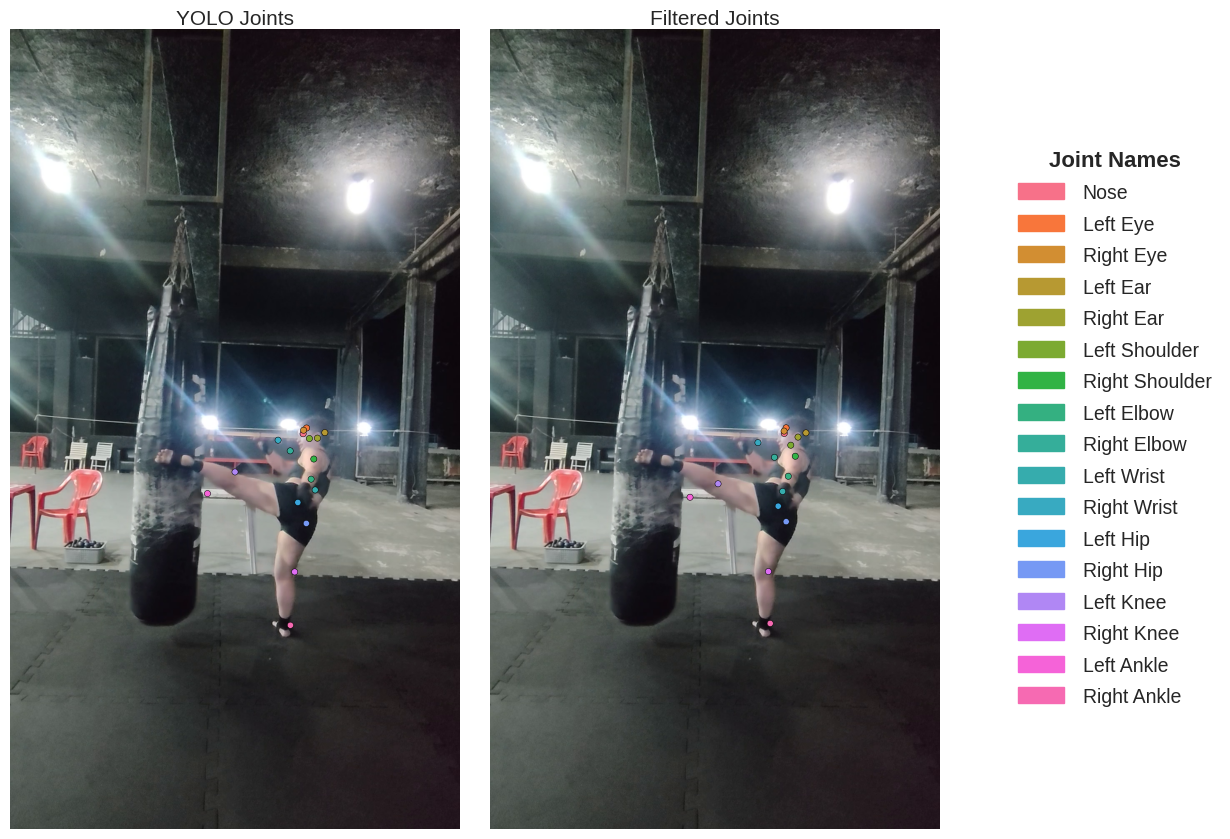

In [49]:
# Generate joint label list (ensure correct number of joint names)
joint_labels = [
    'Nose', 'Left Eye', 'Right Eye', 'Left Ear', 'Right Ear',
    'Left Shoulder', 'Right Shoulder', 'Left Elbow', 'Right Elbow',
    'Left Wrist', 'Right Wrist', 'Left Hip', 'Right Hip',
    'Left Knee', 'Right Knee', 'Left Ankle', 'Right Ankle'
][:num_joints]

frame_to_visualize = 4512                          # Frame index to visualize
original_frame = skeleton_data_2d[frame_to_visualize, :, :]   # YOLO detections
filtered_frame = filtered_skeleton_2d[frame_to_visualize, :, :] # Filtered output

cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_to_visualize)    # Set to desired frame
ret, frame_img = cap.read()
cap.release()

if not ret:
    print("Could not read the frame for visualization.")
else:
    frame_img = cv2.cvtColor(frame_img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
    # Create DataFrames for plotting: one for YOLO, one for filtered
    yolo_df = pd.DataFrame(original_frame, columns=["x", "y"])
    yolo_df['Type'] = "YOLO"
    yolo_df['Joint'] = joint_labels

    filt_df = pd.DataFrame(filtered_frame, columns=["x", "y"])
    filt_df['Type'] = "Filtered"
    filt_df['Joint'] = joint_labels

    # Concatenate for joint colored scatter plot
    all_points = pd.concat([yolo_df, filt_df], ignore_index=True)
    palette = sns.color_palette("husl", len(joint_labels))
    joint_color_dict = {joint: palette[i] for i, joint in enumerate(joint_labels)}

    fig, axes = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'wspace': 0})

    for ax, kind in zip(axes, ["YOLO", "Filtered"]):
        ax.imshow(frame_img)  # Show base frame
        curr = all_points[all_points["Type"] == kind]
        sns.scatterplot(
            data=curr, x="x", y="y", hue="Joint", palette=joint_color_dict,
            ax=ax, s=20, edgecolor="black", legend=False, zorder=2
        )
        ax.set_title(f"{kind} Joints", fontsize=15, pad=0.5)
        ax.axis('off')

    # Draw legend with joint color codes
    handles = [mpatches.Patch(color=joint_color_dict[j], label=j) for j in joint_labels]
    legend = fig.legend(
        handles=handles,
        loc="center",
        bbox_to_anchor=(0.9, 0.5),
        borderaxespad=0,
        frameon=False,
        title="Joint Names"
    )
    legend.set_title("Joint Names", prop={'size': 16, 'weight': 'bold'})
    plt.setp(legend.get_texts(), fontsize=14)

    plt.subplots_adjust(
        left=0.2, right=0.8, bottom=0, top=1, wspace=0.5, hspace=0
    )

    plt.show()           # Display comparative plot

---
## 5. Results and Metrics Analysis

We now analyze the UKF and raw YOLO performance across all sequences from the Penn Action Dataset, parsing the log file and displaying sequences with the most improvement.

---

### Understanding the MPJPE and F1 Metrics

#### Mean Per Joint Position Error (MPJPE)

- **Definition:**
  MPJPE measures the average Euclidean distance (in pixels) between the predicted joint positions and the corresponding ground truth locations, across all joints and frames.

- **Mathematical Expression:**
  $$
  \text{MPJPE} = \frac{1}{NF} \sum_{f=1}^{F} \sum_{n=1}^{N} \left\| \hat{\mathbf{p}}_{f,n} - \mathbf{p}^{\text{GT}}_{f,n} \right\|_2
  $$
  - \( $N$ \): number of joints
  - \( $F$ \): number of frames
  - \( $\hat{\mathbf{p}}_{f,n}$ \): estimated position for joint \( n \) in frame \( f \)
  - \( $\mathbf{p}^{\text{GT}}_{f,n}$ \): ground truth position

- **Interpretation:**
  Lower MPJPE values indicate more precise localization of joints, reflecting higher spatial accuracy for pose estimation models.


#### F1 Score for Pose Detection

- **Definition:**
  The F1 score balances precision (how many detected joints are correct) and recall (how many ground-truth joints are detected), measuring the reliability of detection for visible joints within a set pixel threshold.

- **Computation:**
  - **True Positives (TP):** Number of visible joints detected within the threshold.
  - **False Positives (FP):** Detected joints where there is no matching ground truth within the threshold.
  - **False Negatives (FN):** Visible ground-truth joints missed by the detector.

  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$
  $$
  \text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

- **Interpretation:**
  The F1 score (ranging from 0 to 1) summarizes both how often the model detects the correct joints and how many correct detections are made, providing a robust measure of detection reliability, accounting for both missed joints and false alarms.

---

Both metrics together provide a comprehensive assessment: MPJPE reflects the spatial accuracy of each keypoint, while the F1 score reveals the practical effectiveness of detection and tracking in varied, possibly noisy, conditions.


In [50]:
# --- Log File Parsing and Results Analysis ---

log_file_path = 'UKF_benchmark_log.txt'  # Path to the log file generated during benchmarking
results = []
try:
    with open(log_file_path, 'r') as f:
        for line in f:
            # Search each line for benchmark metrics using a regex pattern
            match = re.search(
                r"Seq (\d+): Raw_MPJPE=([\d.]+), Filtered_MPJPE=([\d.]+), Raw_F1=([\d.]+), Filtered_F1=([\d.]+)",
                line
            )
            # If the pattern matches, extract and append results for this sequence
            if match:
                results.append({
                    "Sequence ID": match.group(1),
                    "Raw MPJPE": float(match.group(2)),
                    "Filtered MPJPE": float(match.group(3)),
                    "Raw F1": float(match.group(4)),
                    "Filtered F1": float(match.group(5))
                })
except FileNotFoundError:
    print(f"ERROR: Could not find the log file at '{log_file_path}'. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

if results:
    df = pd.DataFrame(results)  # Organize results into a DataFrame for analysis
    # Calculate improvement percentages for MPJPE and F1
    df['MPJPE Improvement (%)'] = (df['Raw MPJPE'] - df['Filtered MPJPE']) / df['Raw MPJPE'] * 100
    df['F1 Improvement (%)'] = np.where(
        df['Raw F1'] > 0,
        (df['Filtered F1'] - df['Raw F1']) / df['Raw F1'] * 100,
        0.0
    )
    # Filter sequences where each metric improved
    df_mpjpe_improved = df[df['MPJPE Improvement (%)'] > 0]
    df_f1_improved = df[df['F1 Improvement (%)'] > 0]

    # Print overall statistics and improvements across the dataset
    print("\n" + "="*28 + " OVERALL STATS " + "="*29)
    print("\n--- Positional Accuracy (MPJPE) ---")
    print(f"Number of sequences where filter improved accuracy: {len(df_mpjpe_improved)} out of {len(df)}")
    print(f"Average improvement in those specific sequences:  {df_mpjpe_improved['MPJPE Improvement (%)'].mean():.2f}%")
    print("\n--- Detection Reliability (F1-Score) ---")
    print(f"Number of sequences where filter improved F1-Score: {len(df_f1_improved)} out of {len(df)}")
    print(f"Average improvement in those specific sequences:    {df_f1_improved['F1 Improvement (%)'].mean():.2f}%")

    # Display the top 10 sequences with greatest MPJPE improvement
    df_sorted = df_mpjpe_improved.sort_values(by="MPJPE Improvement (%)", ascending=False)
    print("\n" + "="*20 + " TOP 10 MPJPE IMPROVEMENTS " + "="*21)
    pd.set_option('display.precision', 4)
    top_10_display = df_sorted[[
        'Sequence ID', 'Raw MPJPE', 'Filtered MPJPE', 'MPJPE Improvement (%)'
    ]].head(10)
    print(top_10_display.to_string(index=False))
    print("\n" + "="*71)

    # Display the top 10 sequences with greatest F1 improvement
    df_sorted_f1 = df_f1_improved.sort_values(by="F1 Improvement (%)", ascending=False)
    print("\n" + "="*20 + " TOP 10 F1 SCORE IMPROVEMENTS " + "="*21)
    top_10_f1_display = df_sorted_f1[
        ['Sequence ID', 'Raw F1', 'Filtered F1', 'F1 Improvement (%)']
    ].head(10)
    print(top_10_f1_display.to_string(index=False))
    print("\n" + "="*71)
else:
    print("Could not find any valid results to analyze in the log file.")


============================ OVERALL STATS =============================

--- Positional Accuracy (MPJPE) ---
Number of sequences where filter improved accuracy: 1135 out of 2326
Average improvement in those specific sequences:  2.35%

--- Detection Reliability (F1-Score) ---
Number of sequences where filter improved F1-Score: 747 out of 2326
Average improvement in those specific sequences:    6.91%

==================== TOP 10 MPJPE IMPROVEMENTS =====================
Sequence ID  Raw MPJPE  Filtered MPJPE  MPJPE Improvement (%)
       2239     170.73           13.13                92.3095
       2060     230.27           71.25                69.0581
       2001      32.84           10.77                67.2046
       1454     147.33           55.96                62.0172
       1459     189.00           84.02                55.5450
       1492     159.17           99.30                37.6139
       0434     221.19          139.25                37.0451
       0246      28.81        

---

## 6. Conclusions and Next Steps

- The UKF provides temporal smoothing and can improve accuracy over raw frame-by-frame detections, especially with noisy or occluded pose outputs.
- Further improvement can be achieved by refining process/measurement noise or adapting filter for 3D or velocity-based models.
- Next: experiment with other datasets, real-time pipelines, or edge-devices.

---
